In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')

In [3]:
# 预测第一天用药
x = df.iloc[:,5:5+72+2000]
y = df.iloc[:,5+72+2000:5+72+2000+300]
from sklearn.impute import SimpleImputer

from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

x = imp.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
from keras import backend as K
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)



In [4]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=512,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2072, label_dim =300
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1061376   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 300)               153900    
                                                                 
Total params: 2,003,244
Trainable params: 2,003,244
Non-trainable params: 0
________________________________________________________________

110/110 [==============================] - 2s 19ms/step - loss: 0.1178 - JI: 0.3421 - val_loss: 0.1162 - val_JI: 0.2994
Epoch 55/500
110/110 [==============================] - 2s 18ms/step - loss: 0.2074 - JI: 0.3420 - val_loss: 0.1191 - val_JI: 0.2854
Epoch 56/500
110/110 [==============================] - 2s 19ms/step - loss: 0.1426 - JI: 0.3405 - val_loss: 0.1213 - val_JI: 0.2810
Epoch 57/500
110/110 [==============================] - 2s 17ms/step - loss: 0.1115 - JI: 0.3326 - val_loss: 0.1244 - val_JI: 0.2845
Epoch 58/500
110/110 [==============================] - 2s 17ms/step - loss: 0.4416 - JI: 0.3253 - val_loss: 0.1178 - val_JI: 0.2919
Epoch 59/500
110/110 [==============================] - 2s 18ms/step - loss: 0.1149 - JI: 0.3288 - val_loss: 0.1178 - val_JI: 0.2951
Epoch 60/500
110/110 [==============================] - 2s 18ms/step - loss: 0.1090 - JI: 0.3391 - val_loss: 0.1195 - val_JI: 0.2902
Epoch 61/500
110/110 [==============================] - 2s 17ms/step - loss: 0.124

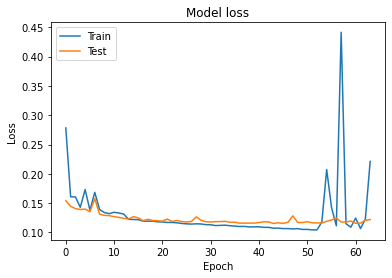

验证集上的最优结果是0.30425068736076355,对应训练轮次是46


0.30425068736076355

In [7]:
# 预测第一天用药
train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num=3)

create model. feature_dim =2072, label_dim =300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               1061376   
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 300)               153900    
                                                                 
Total params: 1,477,932
Trainable params: 1,477,932
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 4s 26ms/step - loss: 0.5328 - JI: 0.0883 - val_loss: 0.1619 - val_JI: 0.1104
Epoch 2/500
110/110 [==============================] - ETA: 0s - loss: 0.1793 - JI: 0.12 - 2s 22ms/step - loss: 0.1788 - JI: 0.1

Epoch 56/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1083 - JI: 0.3301 - val_loss: 0.1153 - val_JI: 0.2961
Epoch 57/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1072 - JI: 0.3338 - val_loss: 0.1151 - val_JI: 0.3018
Epoch 58/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1062 - JI: 0.3385 - val_loss: 0.1163 - val_JI: 0.2976
Epoch 59/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1067 - JI: 0.3378 - val_loss: 0.1167 - val_JI: 0.2922
Epoch 60/500
110/110 [==============================] - 2s 22ms/step - loss: 0.1063 - JI: 0.3387 - val_loss: 0.1157 - val_JI: 0.2978
Epoch 61/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1057 - JI: 0.3413 - val_loss: 0.1158 - val_JI: 0.3009
Epoch 62/500
110/110 [==============================] - 2s 22ms/step - loss: 0.1071 - JI: 0.3354 - val_loss: 0.1155 - val_JI: 0.2960
Epoch 63/500
110/110 [==============================] - 2s 23ms/step 

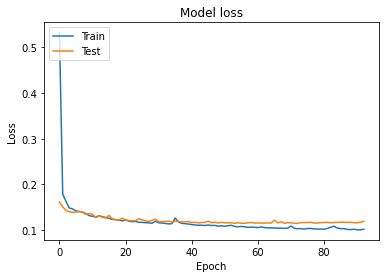

验证集上的最优结果是0.306833416223526,对应训练轮次是91


0.306833416223526

In [8]:
# 预测第一天用药
train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num=1)

create model. feature_dim =2072, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2048)              4245504   
                                                                 
 dense_9 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_10 (Dense)            (None, 300)               614700    
                                                                 
Total params: 9,056,556
Trainable params: 9,056,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 14s 115ms/step - loss: 0.9380 - JI: 0.0873 - val_loss: 0.1576 - val_JI: 0.1150
Epoch 2/500
110/110 [==============================] - 12s 111ms/step - loss: 0.1598 - JI: 0.1666 - val_loss: 0.1598 - val_JI:

110/110 [==============================] - 7s 64ms/step - loss: 0.1278 - JI: 0.3523 - val_loss: 0.1159 - val_JI: 0.3076
Epoch 56/500
110/110 [==============================] - 7s 65ms/step - loss: 0.8185 - JI: 0.3469 - val_loss: 0.1194 - val_JI: 0.2951
Epoch 57/500
110/110 [==============================] - 7s 64ms/step - loss: 0.1105 - JI: 0.3438 - val_loss: 0.1189 - val_JI: 0.3019
Epoch 58/500
110/110 [==============================] - 7s 64ms/step - loss: 0.1026 - JI: 0.3529 - val_loss: 0.1182 - val_JI: 0.3012
Epoch 59/500
110/110 [==============================] - 7s 65ms/step - loss: 0.1022 - JI: 0.3550 - val_loss: 0.1246 - val_JI: 0.2861
Epoch 60/500
110/110 [==============================] - 7s 68ms/step - loss: 0.1020 - JI: 0.3556 - val_loss: 0.1177 - val_JI: 0.3037
Epoch 61/500
110/110 [==============================] - 8s 74ms/step - loss: 0.1012 - JI: 0.3583 - val_loss: 0.1181 - val_JI: 0.2992
Epoch 62/500
110/110 [==============================] - 8s 74ms/step - loss: 0.099

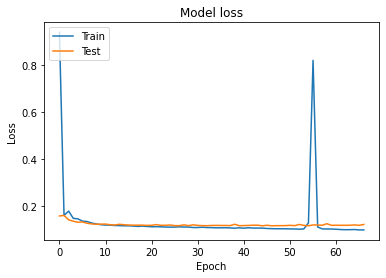

验证集上的最优结果是0.3098229169845581,对应训练轮次是47
create model. feature_dim =2072, label_dim =300
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1024)              2122752   
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 300)               307500    
                                                                 
Total params: 3,479,852
Trainable params: 3,479,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 26ms/step - loss: 0.5793 - JI: 0.0884 - val_loss: 0.2252 - val_JI: 0.0929
Epoch 2/500
110/110 [==============================] - 3s 25ms/step - loss: 0.1777 - JI: 

Epoch 56/500
110/110 [==============================] - 3s 25ms/step - loss: 0.1042 - JI: 0.3471 - val_loss: 0.1168 - val_JI: 0.2968
Epoch 57/500
110/110 [==============================] - 3s 26ms/step - loss: 0.1040 - JI: 0.3487 - val_loss: 0.1159 - val_JI: 0.3044
Epoch 58/500
110/110 [==============================] - 3s 26ms/step - loss: 0.1041 - JI: 0.3490 - val_loss: 0.1182 - val_JI: 0.3023
Epoch 59/500
110/110 [==============================] - 3s 27ms/step - loss: 0.1036 - JI: 0.3507 - val_loss: 0.1171 - val_JI: 0.2963
Epoch 60/500
110/110 [==============================] - 3s 26ms/step - loss: 0.1024 - JI: 0.3560 - val_loss: 0.1155 - val_JI: 0.3067
Epoch 61/500
110/110 [==============================] - 3s 25ms/step - loss: 0.1025 - JI: 0.3554 - val_loss: 0.1161 - val_JI: 0.3048
Epoch 62/500
110/110 [==============================] - 3s 25ms/step - loss: 0.1018 - JI: 0.3588 - val_loss: 0.1169 - val_JI: 0.3014
Epoch 63/500
110/110 [==============================] - 3s 29ms/step 

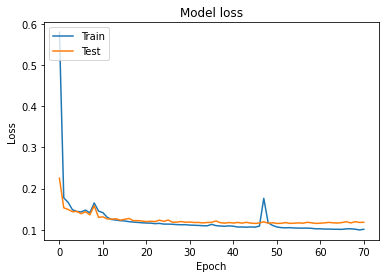

验证集上的最优结果是0.3093261122703552,对应训练轮次是68
create model. feature_dim =2072, label_dim =300
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               1061376   
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,477,932
Trainable params: 1,477,932
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 4s 25ms/step - loss: 0.4595 - JI: 0.0878 - val_loss: 0.1870 - val_JI: 0.0733
Epoch 2/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1675 - JI: 

Epoch 56/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1082 - JI: 0.3302 - val_loss: 0.1154 - val_JI: 0.2994
Epoch 57/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1078 - JI: 0.3324 - val_loss: 0.1183 - val_JI: 0.2873
Epoch 58/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1090 - JI: 0.3281 - val_loss: 0.1161 - val_JI: 0.2954
Epoch 59/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1084 - JI: 0.3298 - val_loss: 0.1179 - val_JI: 0.2895
Epoch 60/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1083 - JI: 0.3311 - val_loss: 0.1158 - val_JI: 0.2918
Epoch 61/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1102 - JI: 0.3333 - val_loss: 0.1226 - val_JI: 0.2715
Epoch 62/500
110/110 [==============================] - 2s 21ms/step - loss: 0.1079 - JI: 0.3319 - val_loss: 0.1171 - val_JI: 0.2917
Epoch 63/500
110/110 [==============================] - 2s 22ms/step 

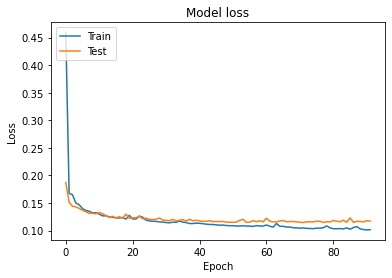

验证集上的最优结果是0.3076644539833069,对应训练轮次是90
create model. feature_dim =2072, label_dim =300
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 256)               530688    
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 300)               77100     
                                                                 
Total params: 673,580
Trainable params: 673,580
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 16ms/step - loss: 0.5547 - JI: 0.0846 - val_loss: 0.1705 - val_JI: 0.1038
Epoch 2/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1694 - JI: 0.12

Epoch 56/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1191 - JI: 0.2845 - val_loss: 0.1195 - val_JI: 0.2754
Epoch 57/500
110/110 [==============================] - 1s 14ms/step - loss: 0.1191 - JI: 0.2873 - val_loss: 0.1203 - val_JI: 0.2789
Epoch 58/500
110/110 [==============================] - 2s 14ms/step - loss: 0.1187 - JI: 0.2900 - val_loss: 0.1237 - val_JI: 0.2592
Epoch 59/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1168 - JI: 0.2922 - val_loss: 0.1198 - val_JI: 0.2798
Epoch 60/500
110/110 [==============================] - 1s 12ms/step - loss: 0.1155 - JI: 0.2989 - val_loss: 0.1186 - val_JI: 0.2754
Epoch 61/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1164 - JI: 0.3015 - val_loss: 0.1195 - val_JI: 0.2783
Epoch 62/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1154 - JI: 0.3037 - val_loss: 0.1185 - val_JI: 0.2851
Epoch 63/500
110/110 [==============================] - 1s 14ms/step 

110/110 [==============================] - 1s 13ms/step - loss: 0.1191 - JI: 0.3346 - val_loss: 0.1167 - val_JI: 0.2940
Epoch 118/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1078 - JI: 0.3332 - val_loss: 0.1160 - val_JI: 0.2955
Epoch 119/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1074 - JI: 0.3350 - val_loss: 0.1159 - val_JI: 0.2948
Epoch 120/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1068 - JI: 0.3367 - val_loss: 0.1146 - val_JI: 0.3030
Epoch 121/500
110/110 [==============================] - 1s 14ms/step - loss: 0.1071 - JI: 0.3354 - val_loss: 0.1168 - val_JI: 0.2985
Epoch 122/500
110/110 [==============================] - 2s 14ms/step - loss: 0.1070 - JI: 0.3356 - val_loss: 0.1174 - val_JI: 0.2975
Epoch 123/500
110/110 [==============================] - 1s 14ms/step - loss: 0.1076 - JI: 0.3343 - val_loss: 0.1213 - val_JI: 0.2819
Epoch 124/500
110/110 [==============================] - 1s 13ms/step - loss

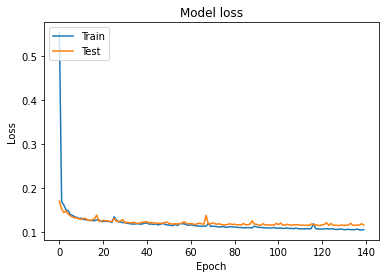

验证集上的最优结果是0.30630719661712646,对应训练轮次是136
create model. feature_dim =2072, label_dim =300
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               265344    
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 300)               38700     
                                                                 
Total params: 320,556
Trainable params: 320,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 15ms/step - loss: 0.5593 - JI: 0.0804 - val_loss: 0.1614 - val_JI: 0.0962
Epoch 2/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1658 - JI: 0.

Epoch 56/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1110 - JI: 0.3173 - val_loss: 0.1170 - val_JI: 0.2906
Epoch 57/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1106 - JI: 0.3187 - val_loss: 0.1153 - val_JI: 0.2934
Epoch 58/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1099 - JI: 0.3224 - val_loss: 0.1165 - val_JI: 0.2941
Epoch 59/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1120 - JI: 0.3202 - val_loss: 0.1149 - val_JI: 0.2998
Epoch 60/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1105 - JI: 0.3206 - val_loss: 0.1195 - val_JI: 0.2844
Epoch 61/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1103 - JI: 0.3227 - val_loss: 0.1162 - val_JI: 0.2883
Epoch 62/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1110 - JI: 0.3197 - val_loss: 0.1165 - val_JI: 0.2915
Epoch 63/500
110/110 [==============================] - 1s 10ms/step 

110/110 [==============================] - 1s 11ms/step - loss: 0.1031 - JI: 0.3516 - val_loss: 0.1163 - val_JI: 0.2935
Epoch 118/500
110/110 [==============================] - 1s 5ms/step - loss: 0.1032 - JI: 0.3510 - val_loss: 0.1144 - val_JI: 0.3072
Epoch 119/500
110/110 [==============================] - 1s 5ms/step - loss: 0.1033 - JI: 0.3512 - val_loss: 0.1138 - val_JI: 0.3090
Epoch 120/500
110/110 [==============================] - 1s 5ms/step - loss: 0.1026 - JI: 0.3537 - val_loss: 0.1135 - val_JI: 0.3120
Epoch 121/500
110/110 [==============================] - 1s 5ms/step - loss: 0.1060 - JI: 0.3398 - val_loss: 0.1163 - val_JI: 0.2992
Epoch 122/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1037 - JI: 0.3486 - val_loss: 0.1166 - val_JI: 0.2974
Epoch 123/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1030 - JI: 0.3525 - val_loss: 0.1137 - val_JI: 0.3069
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1

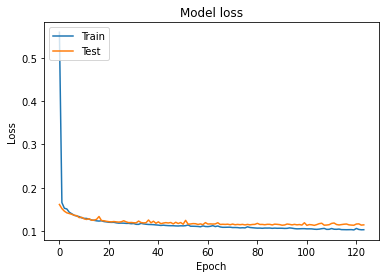

验证集上的最优结果是0.3120354413986206,对应训练轮次是120
create model. feature_dim =2072, label_dim =300
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                132672    
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 300)               19500     
                                                                 
Total params: 156,332
Trainable params: 156,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 11ms/step - loss: 0.7540 - JI: 0.0631 - val_loss: 0.1656 - val_JI: 0.0767
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1669 - JI: 0.08

110/110 [==============================] - 1s 8ms/step - loss: 0.1158 - JI: 0.2977 - val_loss: 0.1186 - val_JI: 0.2805
Epoch 57/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1157 - JI: 0.2981 - val_loss: 0.1193 - val_JI: 0.2791
Epoch 58/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1158 - JI: 0.2978 - val_loss: 0.1188 - val_JI: 0.2839
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1154 - JI: 0.2999 - val_loss: 0.1183 - val_JI: 0.2797
Epoch 60/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1150 - JI: 0.3014 - val_loss: 0.1183 - val_JI: 0.2796
Epoch 61/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1146 - JI: 0.3030 - val_loss: 0.1186 - val_JI: 0.2789
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1146 - JI: 0.3033 - val_loss: 0.1204 - val_JI: 0.2854
Epoch 63/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1146 - JI: 

Epoch 118/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1093 - JI: 0.3244 - val_loss: 0.1164 - val_JI: 0.2901
Epoch 119/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1093 - JI: 0.3243 - val_loss: 0.1166 - val_JI: 0.2925
Epoch 120/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1098 - JI: 0.3219 - val_loss: 0.1167 - val_JI: 0.2949
Epoch 121/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1094 - JI: 0.3241 - val_loss: 0.1170 - val_JI: 0.2949
Epoch 122/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1096 - JI: 0.3245 - val_loss: 0.1210 - val_JI: 0.2857
Epoch 123/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1096 - JI: 0.3237 - val_loss: 0.1172 - val_JI: 0.2876
Epoch 124/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1093 - JI: 0.3249 - val_loss: 0.1172 - val_JI: 0.2937
Epoch 125/500
110/110 [==============================] - 1s 9ms/step 

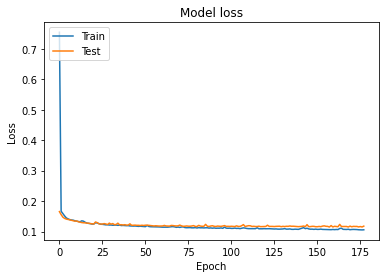

验证集上的最优结果是0.3018777668476105,对应训练轮次是177
create model. feature_dim =2072, label_dim =300
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 32)                66336     
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 300)               9900      
                                                                 
Total params: 77,292
Trainable params: 77,292
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 4s 25ms/step - loss: 0.7419 - JI: 0.0495 - val_loss: 0.1637 - val_JI: 0.0552
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1722 - JI: 0.0530

110/110 [==============================] - 0s 4ms/step - loss: 0.1396 - JI: 0.2046 - val_loss: 0.1392 - val_JI: 0.2017
Epoch 57/500
110/110 [==============================] - 0s 4ms/step - loss: 0.1398 - JI: 0.2047 - val_loss: 0.1392 - val_JI: 0.1950
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1400 - JI: 0.2034 - val_loss: 0.1390 - val_JI: 0.2040
Epoch 59/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1397 - JI: 0.2047 - val_loss: 0.1392 - val_JI: 0.2032
Epoch 60/500
110/110 [==============================] - 1s 12ms/step - loss: 0.1397 - JI: 0.2055 - val_loss: 0.1512 - val_JI: 0.1590
Epoch 61/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1428 - JI: 0.1955 - val_loss: 0.1390 - val_JI: 0.2027
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1396 - JI: 0.2049 - val_loss: 0.1390 - val_JI: 0.1992
Epoch 63/500
110/110 [==============================] - 1s 10ms/step - loss: 0.1394 - 

Epoch 118/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1368 - JI: 0.2136 - val_loss: 0.1388 - val_JI: 0.1923
Epoch 119/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1373 - JI: 0.2142 - val_loss: 0.1368 - val_JI: 0.2115
Epoch 120/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1371 - JI: 0.2156 - val_loss: 0.1368 - val_JI: 0.2115
Epoch 121/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1368 - JI: 0.2149 - val_loss: 0.1367 - val_JI: 0.2118
Epoch 122/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1365 - JI: 0.2154 - val_loss: 0.1367 - val_JI: 0.2114
Epoch 123/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1363 - JI: 0.2156 - val_loss: 0.1366 - val_JI: 0.2102
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1362 - JI: 0.2163 - val_loss: 0.1366 - val_JI: 0.2100
Epoch 125/500
110/110 [==============================] - 1s 8ms/step 

110/110 [==============================] - 1s 9ms/step - loss: 0.1354 - JI: 0.2175 - val_loss: 0.1361 - val_JI: 0.2057
Epoch 180/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1350 - JI: 0.2194 - val_loss: 0.1361 - val_JI: 0.2097
Epoch 181/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1351 - JI: 0.2193 - val_loss: 0.1371 - val_JI: 0.2134
Epoch 182/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1353 - JI: 0.2185 - val_loss: 0.1378 - val_JI: 0.1915
Epoch 183/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1356 - JI: 0.2170 - val_loss: 0.1364 - val_JI: 0.2132
Epoch 184/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1352 - JI: 0.2181 - val_loss: 0.1365 - val_JI: 0.2032
Epoch 185/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1351 - JI: 0.2190 - val_loss: 0.1371 - val_JI: 0.2138
Epoch 186/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1351

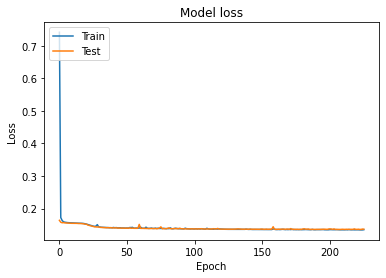

验证集上的最优结果是0.21574510633945465,对应训练轮次是187
create model. feature_dim =2072, label_dim =300
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 16)                33168     
                                                                 
 dense_30 (Dense)            (None, 16)                272       
                                                                 
 dense_31 (Dense)            (None, 300)               5100      
                                                                 
Total params: 38,540
Trainable params: 38,540
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 11ms/step - loss: 0.5429 - JI: 0.0523 - val_loss: 0.1644 - val_JI: 0.0551
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1668 - JI: 0.058

110/110 [==============================] - 1s 8ms/step - loss: 0.1312 - JI: 0.2359 - val_loss: 0.1327 - val_JI: 0.2230
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1318 - JI: 0.2350 - val_loss: 0.1315 - val_JI: 0.2331
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1322 - JI: 0.2342 - val_loss: 0.1326 - val_JI: 0.2293
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1313 - JI: 0.2378 - val_loss: 0.1311 - val_JI: 0.2291
Epoch 60/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1301 - JI: 0.2395 - val_loss: 0.1307 - val_JI: 0.2316
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1301 - JI: 0.2403 - val_loss: 0.1323 - val_JI: 0.2186
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1297 - JI: 0.2407 - val_loss: 0.1307 - val_JI: 0.2307
Epoch 63/500
110/110 [==============================] - 1s 9ms/step - loss: 0.1294 - JI: 

110/110 [==============================] - 1s 7ms/step - loss: 0.1240 - JI: 0.2601 - val_loss: 0.1266 - val_JI: 0.2492
Epoch 119/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1252 - JI: 0.2576 - val_loss: 0.1272 - val_JI: 0.2490
Epoch 120/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1243 - JI: 0.2593 - val_loss: 0.1264 - val_JI: 0.2445
Epoch 121/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1239 - JI: 0.2600 - val_loss: 0.1279 - val_JI: 0.2466
Epoch 122/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1241 - JI: 0.2596 - val_loss: 0.1258 - val_JI: 0.2490
Epoch 123/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1235 - JI: 0.2615 - val_loss: 0.1265 - val_JI: 0.2478
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1233 - JI: 0.2621 - val_loss: 0.1262 - val_JI: 0.2479
Epoch 125/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1231

Epoch 180/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1208 - JI: 0.2715 - val_loss: 0.1238 - val_JI: 0.2533
Epoch 181/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1204 - JI: 0.2732 - val_loss: 0.1246 - val_JI: 0.2572
Epoch 182/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1207 - JI: 0.2727 - val_loss: 0.1252 - val_JI: 0.2480
Epoch 183/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1204 - JI: 0.2738 - val_loss: 0.1241 - val_JI: 0.2535
Epoch 184/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1202 - JI: 0.2743 - val_loss: 0.1288 - val_JI: 0.2375
Epoch 185/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1205 - JI: 0.2726 - val_loss: 0.1242 - val_JI: 0.2499
Epoch 186/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1202 - JI: 0.2746 - val_loss: 0.1245 - val_JI: 0.2560
Epoch 187/500
110/110 [==============================] - 1s 8ms/step 

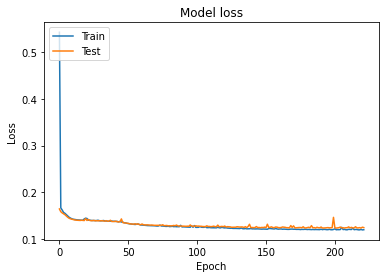

验证集上的最优结果是0.25987163186073303,对应训练轮次是222


[0.3098229169845581,
 0.3093261122703552,
 0.3076644539833069,
 0.30630719661712646,
 0.3120354413986206,
 0.3018777668476105,
 0.21574510633945465,
 0.25987163186073303]

In [9]:
# 调节隐层单元数
result_list = []
hidden_layer_units_list=[2048,1024,512,256,128,64,32,16]
for i in hidden_layer_units_list:
    result_list.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_units=i))
result_list